# Melbourne city council Pedestrian Footfall dataset Analysis

Dataset: https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-2009-to-Present-counts-/b2ak-trbp

Note: you will need the Jupyer Lab plotly extension installed: https://plotly.com/python/getting-started

In [182]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from datetime import datetime
from pathlib import Path

import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

from utils import load_and_clean_pedestrian_data

pd.options.plotting.backend = "plotly"
data_path = Path("../data/Pedestrian_Counting_System___2009_to_Present__counts_per_hour_.csv")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
foot_df = load_and_clean_pedestrian_data(data_path)
foot_df.head()

,ID,Date_Time,Year,Month,Mdate,Day,Time,Sensor_ID,Sensor_Name,Hourly_Counts,datetime,datetime_flat_year
0,2887628,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,34,Flinders St-Spark La,300,2019-11-01 17:00:00,2000-11-01 17:00:00
1,2887629,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,39,Alfred Place,604,2019-11-01 17:00:00,2000-11-01 17:00:00
2,2887630,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,37,Lygon St (East),216,2019-11-01 17:00:00,2000-11-01 17:00:00
3,2887631,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627,2019-11-01 17:00:00,2000-11-01 17:00:00
4,2887632,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,36,Queen St (West),774,2019-11-01 17:00:00,2000-11-01 17:00:00


In [15]:
# perform filtering
sensors = [
    'Flinders St-Spark La', 'Alfred Place', 'Lygon St (East)',
    'Lonsdale St-Spring St (West)', 'Queen St (West)',
    'St Kilda Rd-Alexandra Gardens', 'Grattan St-Swanston St (West)',
    'Monash Rd-Swanston St (West)', 'Tin Alley-Swanston St (West)',
    'Southbank', 'Little Collins St-Swanston St (East)'
]
df = foot_df
df = df[df["Year"] == 2018]
df = df[df["Month"] == "December"]        
df = df[df["Sensor_Name"].isin(set(sensors))]
df.shape

(7843, 11)

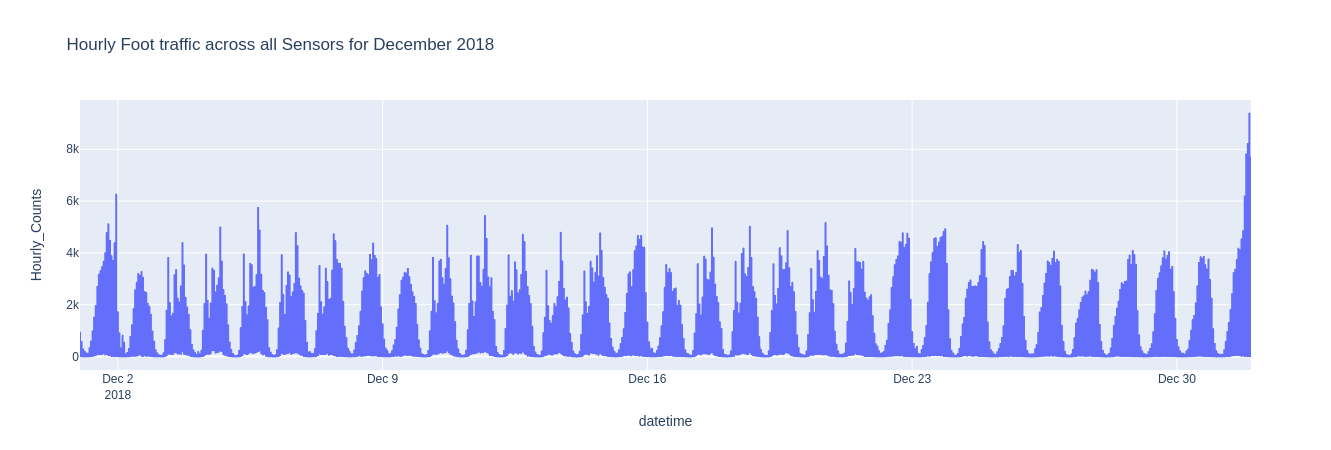

In [16]:
# Initial attempt at plottling sensors
px.line(df, y="Hourly_Counts", x="datetime", title="Hourly Foot traffic across all Sensors for December 2018")

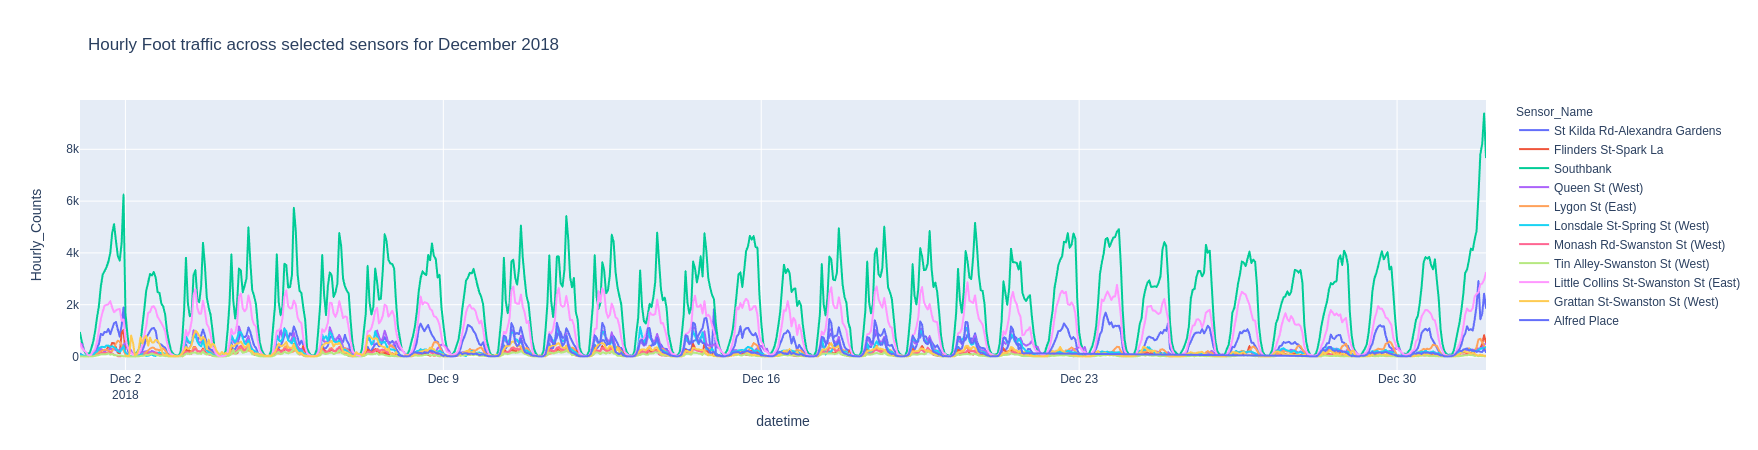

In [39]:
# Initial attempt at plottling sensors
# can do line_group first
px.line(df, y="Hourly_Counts", x="datetime", color="Sensor_Name", title="Hourly Foot traffic across selected sensors for December 2018")

Observations:
* plotting on same plot makes readability hard 
* hard to compare the relative shape due to different scales
* annoying having to keep re-running filtering cell with new parameters

In [112]:
def filter_foot_df(df, year=None, month=None, sensors=None):
    if year is not None:
        df = df[df["Year"] == year]
    if month is not None:
        df = df[df["Month"].isin(set(month))]
    if sensors is not None:
        df = df[df["Sensor_Name"].isin(set(sensor))]
    return df

In [135]:
import collections

def issequence(obj):
    if isinstance(obj, str):
        return False
    return isinstance(obj, collections.abc.Sequence)


def filter_foot_df(df, year=None, month=None, sensor=None):
    if year is not None:
        if not issequence(year):
            year = [year]
        df = df[df["Year"].isin(set(year))]
    if month is not None:
        if not issequence(month):
            month = [month]
        df = df[df["Month"].isin(set(month))]
    if sensor is not None:
        if not issequence(sensor):
            sensor = [sensor]
        df = df[df["Sensor_Name"].isin(set(sensor))]
    if len(df) == 0:
        raise Exception("No matching records")
    return df

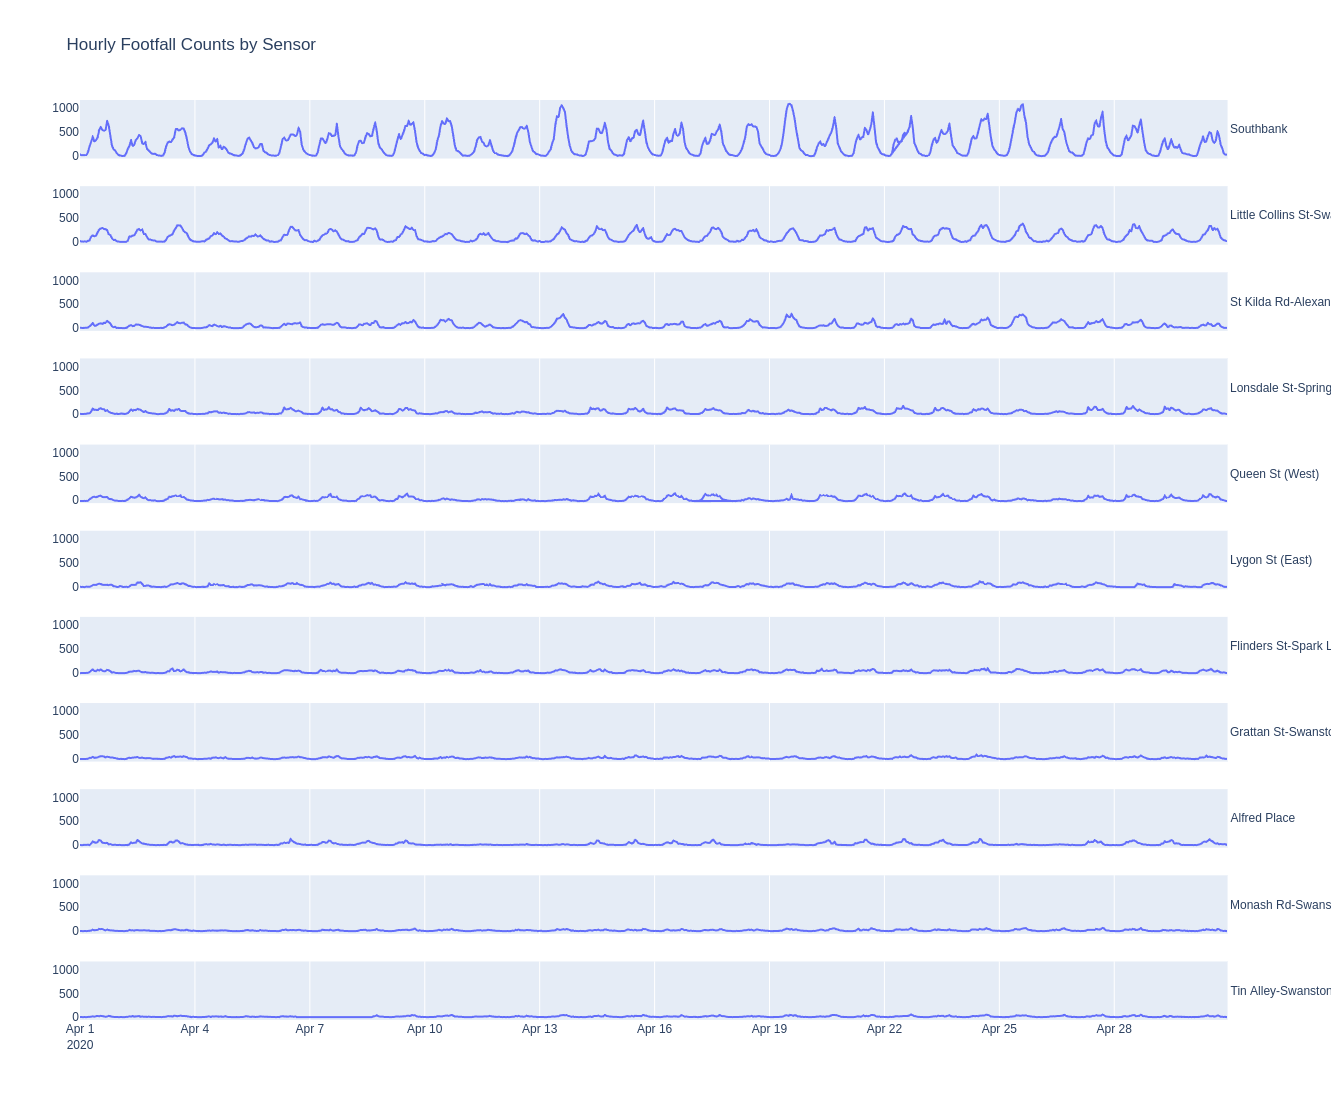

In [176]:
def plot_sensors(df, sensor=None, year=None, month=None, same_yscale=False, row_height=100, **kwargs):
    df = filter_foot_df(df, year=year, month=month, sensor=sensor)
    
    sensor_order = df.groupby("Sensor_Name")["Hourly_Counts"].sum().sort_values(ascending=False)
    
    # make the figure with Plotly Express
    fig = px.line(
        df, y="Hourly_Counts", x="datetime", facet_row="Sensor_Name", title="Hourly Footfall Counts by Sensor", 
        category_orders={'Sensor_Name': list(sensor_order.index)}, height=len(sensor_order)*row_height, **kwargs
    )
    
    # update figure produced by Plotly Express with fine-tuning 
    fig.update_yaxes(matches=None if same_yscale else "y", showgrid=False, zeroline=False, title_text=None)
    fig.update_xaxes(showgrid=True, title_text=None)
    fig.for_each_annotation(lambda a: a.update(textangle=0, text=a.text.split('=')[-1]))
    return fig

plot_sensors(foot_df, sensor=sensors, year=2020, month="April", same_yscale=False)

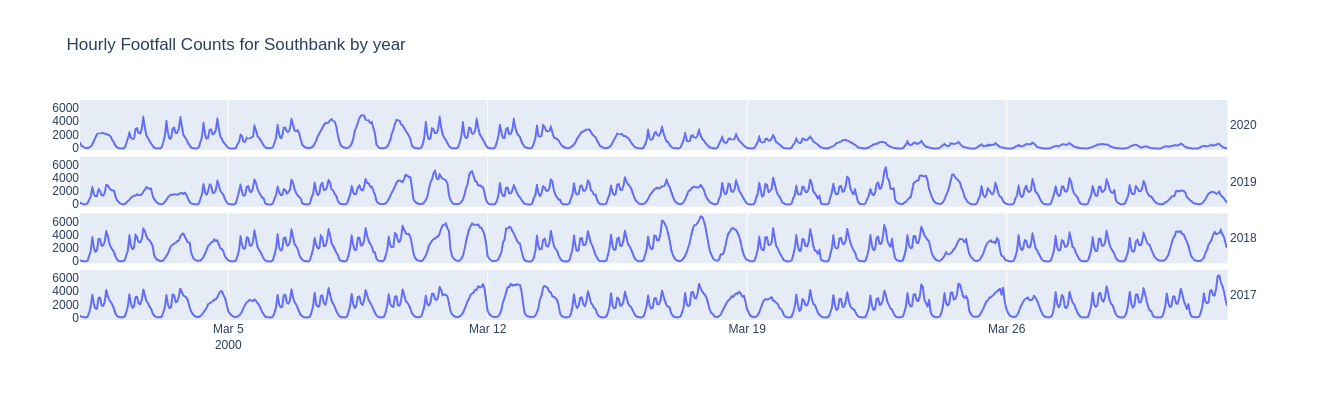

In [181]:
def plot_years(df, sensor=None, year=None, month=None, same_yscale=False, row_height=100, **kwargs):
    df = filter_foot_df(df, year=year, month=month, sensor=sensor)
    
    # prep additional data required 
    year_counts = df.groupby("Year")["Hourly_Counts"].sum().sort_index(ascending=False)
    
    # make the figure with Plotly Express
    fig = px.line(
        df, y="Hourly_Counts", x="datetime_flat_year", facet_row="Year", title=f"Hourly Footfall Counts for {sensor} by year", 
        category_orders={'Year': list(year_counts.index)}, height=len(year_counts)*row_height, **kwargs
    )
    
    # update figure produced by Plotly Express with fine-tuning 
    fig.update_yaxes(matches=None if same_yscale else "y", showgrid=False, zeroline=False, title_text=None)
    fig.update_xaxes(showgrid=True, title_text=None)
    fig.for_each_annotation(lambda a: a.update(textangle=0, text=a.text.split('=')[-1]))
    return fig

plot_years(foot_df, sensor="Southbank", month="March", same_yscale=False)

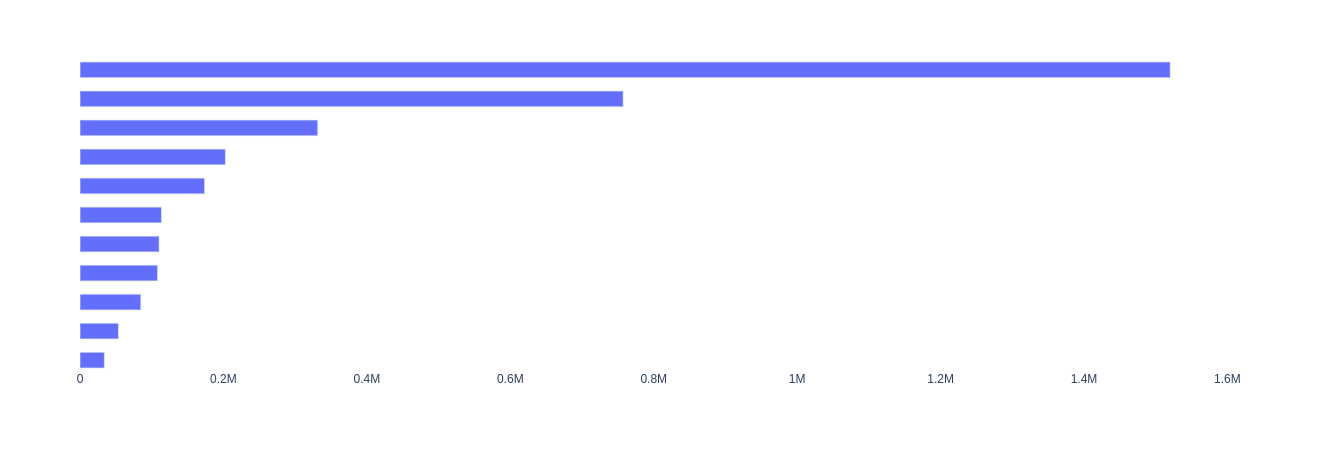

In [120]:
# this could be used to plot alongside the sensor line plots
# TODO: improve hover labels 
def make_facet_bars(df, height=None):
    fig = px.bar(df.groupby("Sensor_Name")["Hourly_Counts"].sum().sort_values(ascending=False).reset_index(), facet_row="Sensor_Name", orientation="h", height=height)
    fig.update_yaxes(matches=None, title_text=None, showticklabels=False)
    fig.update_xaxes(showgrid=False, title_text=None)
    fig.update_layout(showlegend=False, plot_bgcolor="white")
    fig.for_each_annotation(lambda a: a.update(text=""))
    return fig

make_facet_bars(df)